# Actor-critic learning for the Capacitated Vehicle Routing Problem.
## Reinforcement Learning Term Project

### Melike Çolak - N22239753

This study successfully applies the Actor-Critic framework to the Capacitated Vehicle Routing Problem (CVRP), demonstrating its effectiveness in optimizing vehicle routes. By utilizing neural networks and attention mechanisms, the model efficiently handles spatial and temporal dependencies, leading to significant reductions in total travel distance.

## Importing the libraries

In [ ]:
import os
import time
import random
import numpy as np
import matplotlib.pyplot as plt
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from gym import wrappers
from torch.autograd import Variable
from torch.distributions import Categorical
from collections import deque

## Creating a CVRP environment

In [ ]:
import gym
from gym import error, spaces, utils
from gym.utils import seeding
import numpy as np
import random
import copy
import math

class VRPEnv(gym.Env):
  def __init__(self):
    # customer count ('0' is depot)
    self.customer_count = 11
    # the capacity of vehicles
    self.vehicle_capacity = 2

    self.action_space = spaces.Discrete(3)
    self.observation_space = spaces.Box(low=0,high=1, shape=(4,1), dtype=np.float64)
    self.VRP = np.array((self.customer_count,4))
    self._max_episode_steps = 1000
    self.viewer = None
    self.state = None
    self.steps_beyond_done = None
    self.route = []
    self.route.append(0)
    self.previous_action = 0
    self.hn_actor = torch.zeros([1,self.customer_count,128], dtype=torch.float32).to(device)
    self.hn_actor_target = torch.zeros([1,self.customer_count,128], dtype=torch.float32).to(device)


  def reset(self, seed=200):
    if seed == 200:
      seed = int(time.time())
    np.random.seed(seed)
    x_locations = (np.random.rand(self.customer_count)).reshape((self.customer_count,1))
    y_locations = (np.random.rand(self.customer_count)).reshape((self.customer_count,1))
    demand = (np.random.randint(1,9,self.customer_count).reshape((self.customer_count,1))).reshape((self.customer_count,1))/10 # Normalise to between 0.1 and 0.9
    capacity = np.repeat(self.vehicle_capacity,self.customer_count).reshape((self.customer_count,1))
    VRP = np.concatenate((np.concatenate((np.concatenate((x_locations,y_locations), axis=1),demand),axis=1),capacity),axis=1)
    self.VRP = VRP.reshape((self.customer_count,4))
    self.unserved_customers = []
    for i in range(1, self.customer_count):
      self.unserved_customers.append(i)
    self.routes = []
    self.route = []
    self.route.append(0)
    self.VRP[0,2] = 0 # Set the demand at thedepot to 0
    self.state = copy.deepcopy(self.VRP)
    self.previous_action = 0
    return self.state


  def step(self, action):
    # Calculate the reward as the negative euclidean distance
    reward = -((self.state[self.previous_action,0]-self.state[action,0])**2+(self.state[self.previous_action,1]-self.state[action,1])**2)**0.5 # - Euclidean distance between customers
    load = self.state[0,3]
    self.state[:,3] = max(0,(load-self.state[action,2])) # Update the vehicle load
    self.state[action, 2] = max(0,self.state[action,2]-load) # Update the demand at served customer
    done = False
    if action == 0: # Return to the depot
      self.route.append(action) # End route
      self.routes.append(self.route) # Add subroute to list of all routes
      self.route = [] # Initiate new subroute
      self.state[:,3] = self.vehicle_capacity # Refill the vehicle
    self.route.append(action) # Add action to the subroute
    if max(self.state[:,2]) > 0: # If there are unserved customers left
      done = False
    elif max(self.state[:,2]) == 0 and action == 0: # If there are no unserved customers left and we have returned to the depot
      done = True
      self.route.append(0)
    self.previous_action = action # Update the previous action
    return self.state, reward, done


## Let's test the environment step function

In [ ]:
env = VRPEnv() # Create an instance of the environment
state = env.reset() # Reset the environment
action = 2 # Perform action with customer 2
print(state)
state, reward, done = env.step(action) # Perform the actual transition
print(state)

[[0.37373295 0.80802107 0.         2.        ]
 [0.31262051 0.51824804 0.1        2.        ]
 [0.80054744 0.65434    0.8        2.        ]
 [0.93003205 0.33689881 0.1        2.        ]
 [0.49979155 0.96378802 0.1        2.        ]
 [0.99504738 0.91396134 0.8        2.        ]
 [0.90603974 0.44450002 0.5        2.        ]
 [0.73837891 0.16656266 0.1        2.        ]
 [0.13254939 0.21516502 0.1        2.        ]
 [0.65131081 0.03766667 0.7        2.        ]
 [0.84910515 0.33927907 0.1        2.        ]]
[[0.37373295 0.80802107 0.         1.2       ]
 [0.31262051 0.51824804 0.1        1.2       ]
 [0.80054744 0.65434    0.         1.2       ]
 [0.93003205 0.33689881 0.1        1.2       ]
 [0.49979155 0.96378802 0.1        1.2       ]
 [0.99504738 0.91396134 0.8        1.2       ]
 [0.90603974 0.44450002 0.5        1.2       ]
 [0.73837891 0.16656266 0.1        1.2       ]
 [0.13254939 0.21516502 0.1        1.2       ]
 [0.65131081 0.03766667 0.7        1.2       ]
 [0.84910515

## Initialize the Experience Replay memory




In [ ]:
class ReplayBuffer(object):

  def __init__(self, max_size=1e6):
    self.storage = []
    self.max_size = max_size
    self.ptr = 0

  def add(self, transition):
    if len(self.storage) == self.max_size:
      #self.storage[int(self.ptr)] = transition
      #self.ptr = (self.ptr + 1) % self.max_size
      self.storage.pop(0)
      self.storage.append(transition)
    else:
      self.storage.append(transition)

  def sample(self, batch_size):
    ind =  np.arange((len(self.storage)-(batch_size+1)),len(self.storage)-1,1)
    #np.random.randint(0, len(self.storage), size=batch_size)
    batch_states, batch_next_states, batch_actions, batch_rewards, batch_dones = [], [], [], [], []
    for i in ind:
      state, next_state, action, reward, done = self.storage[i]
      batch_states.append(np.array(state, copy=False))
      batch_next_states.append(np.array(next_state, copy=False))
      batch_actions.append(np.array(action, copy=False))
      batch_rewards.append(np.array(reward, copy=False))
      batch_dones.append(np.array(done, copy=False))
    return np.array(batch_states), np.array(batch_next_states), np.array(batch_actions), np.array(batch_rewards).reshape(-1, 1), np.array(batch_dones).reshape(-1, 1)

## Build the neural network for the Actor and Actor-target models - contains the attention mechanism

In [ ]:
class Actor(nn.Module):

  def __init__(self, state_dim=4, embed_size = 128):#, action_dim, max_action):
    super(Actor, self).__init__()
    self.embed = nn.Linear((state_dim), embed_size) # Encoding to higher dimensional space - can also be changed to convolutional layer as in the paper
    self.u_t = nn.RNN(embed_size,embed_size,1) # RNN Layer for the attention mechanism
    self.v_t_a = nn.Linear(embed_size,1) # Linear for getting u_t
    self.bar_u_t = nn.RNN(embed_size,embed_size,1) # RNN Layer for the context vector
    self.a_t = nn.Softmax(dim = 1) # Softmax layer for the attention mechanism
    self.v_t_u = nn.Linear(embed_size,1) # Linear for getting u_t
    self.final = nn.Softmax(dim = 1) # Softmax layer for the final output

    self.saved_log_probabilities = [] # Create and empty list for saving the log probabilities of the actions
    self.rewards = [] # Create an empty list for the rewards
    self.dones = [] # Create an empty list for checking whether the episode was completed

  def forward(self, x, hn = env.hn_actor):
    cond1 = (x[:,:,2]<x[:,:,3]).int() # Can we meet the demand
    cond2 = (x[:,:,2]>0).int() # Is there demand at the customer
    mask1 = torch.minimum(cond1,cond2) # Select those customers with demand, and whose demand we can meet
    if torch.sum(mask1[:,1:len(mask1[0])]) == 0: # If only the depot can be visited
      mask1[:,0] = 1
    mask1 = torch.reshape(mask1,(len(x),env.customer_count,1))
    x = self.embed(x)
    u, hn = self.u_t(x, hn)
    u = self.v_t_a(u)
    a = self.a_t(u)
    c = torch.randn(x.shape)
    c = torch.mul(x,a)
    c = torch.sum(c, 0)
    c = torch.reshape(c,(1,env.customer_count,128))
    u_bar, hu = self.bar_u_t(x,c)
    u_bar = self.v_t_u(u_bar)
    output = self.final(u_bar)
    output = torch.mul(output,mask1)
    #print("Before clamp ", output)
    #output = output.log().clamp(epsilon, 1 - epsilon)
    epsilon = 10 ** -44
    output = output.clamp(min=1e-4)
    #print("After clamp ",output)
    output = output.log()#.clamp(epsilon, 1 - epsilon)
    #print("After log ",output)
    output = self.final(output)
    return output

class Actor_Target(nn.Module):

  def __init__(self, state_dim=4, embed_size = 128):#, action_dim, max_action):
    super(Actor_Target, self).__init__()
    self.embed = nn.Linear((state_dim), embed_size) # Encoding to higher dimensional space - can also be changed to convolutional layer as in the paper
    self.u_t = nn.RNN(embed_size,embed_size,1) # RNN Layer for the attention mechanism
    self.v_t_a = nn.Linear(embed_size,1) # Linear for getting u_t
    self.bar_u_t = nn.RNN(embed_size,embed_size,1) # RNN Layer for the context vector
    self.a_t = nn.Softmax(dim = 1) # Softmax layer for the attention mechanism
    self.v_t_u = nn.Linear(embed_size,1) # Linear for getting u_t
    self.final = nn.Softmax(dim = 1) # Softmax layer for the final output

  def forward(self, x, hn = env.hn_actor_target):
    cond1 = (x[:,:,2]<x[:,:,3]).int() # Can we meet the demand
    cond2 = (x[:,:,2]>0).int() # Is there demand at the customer
    mask1 = torch.minimum(cond1,cond2) # Select those customers with demand, and whose demand we can meet
    if torch.sum(mask1[:,1:len(mask1[0])]) == 0: # If only the depot can be visited
      mask1[:,0] = 1
    mask1 = torch.reshape(mask1,(len(x),env.customer_count,1))
    x = self.embed(x)
    u, hn = self.u_t(x, hn)
    u = self.v_t_a(u)
    a = self.a_t(u) # Up to equation (4) now
    c = torch.randn(x.shape)
    c = torch.mul(x,a)
    c = torch.sum(c, 0)
    c = torch.reshape(c,(1,env.customer_count,128))
    u_bar, hu = self.bar_u_t(x,c)
    u_bar = self.v_t_u(u_bar)
    output = self.final(u_bar)
    output = torch.mul(output,mask1)
    output = self.final(torch.log(output))
    return output

## Build the neural network for the Critic and Critic-target model

In [ ]:
class Critic(nn.Module):

  def __init__(self, state_dim=4, action_dim = env.customer_count, embed_size = 128):
    super(Critic, self).__init__()
    # Defining the first Critic neural network
    self.layer_1 = nn.Linear(state_dim, embed_size) # Perform the embedding
    self.layer_2 = nn.Linear(embed_size, embed_size) # Adding the single dense layer
    self.layer_3 = nn.Linear(embed_size, 1) # Adding the output layer

    self.values = [] # Create an empty list to store the predicted values


  def forward(self, x, u): # x is the state, u is the action
    # Forward-Propagation on the Critic Neural Network
    x1 = F.relu(self.layer_1(x))
    ws = torch.mul(x1,u)
    x2 = F.relu(self.layer_2(ws))
    x2 = self.layer_3(x2)
    x2 = torch.sum(x2,1)
    return x2


## Testing the actor and critic networks to confirm their output

In [ ]:
env = VRPEnv()
env.reset()
state = env.reset()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
state = torch.Tensor(state.reshape(1,env.customer_count,4)).to(device)
actor = Actor().to(device)
actor_target = Actor_Target().to(device)
prediction = actor(state)
prediction_target = actor_target(state)
print(prediction)
critic = Critic().to(device)
q_value = critic(state,prediction)
print(q_value)

state, reward, done = env.step(5)
state = torch.Tensor(state.reshape(1,env.customer_count,4)).to(device)
prediction = actor(state)
print(torch.sum(prediction))

tensor([[[1.0907e-04],
         [9.1351e-02],
         [1.0263e-01],
         [1.0691e-01],
         [1.0337e-01],
         [1.1138e-01],
         [8.6095e-02],
         [1.0129e-01],
         [1.0238e-01],
         [1.0266e-01],
         [9.1814e-02]]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4231]], grad_fn=<SumBackward1>)
tensor(1., grad_fn=<SumBackward0>)


## Training Process

In [ ]:
# Selecting the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)

# Building the Training Process into a class
class Actor_Critic(object):

  def __init__(self, state_dim):
    self.actor = Actor_Target(state_dim).to(device)
    self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr = 0.0001)
    self.critic = Critic(state_dim, action_dim).to(device)
    self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr = 0.0001)
    self.max_action = max_action

  def select_action(self, state, state_dim):
    #state_tensor = torch.Tensor(state.reshape(1,env.customer_count,state_dim)).to(device)
    current_Q = actor(state)
    Q = torch.reshape(current_Q,(1,env.customer_count))
    m = Categorical(Q)
    action = m.sample()
    actor.saved_log_probabilities.append(m.log_prob(action))
    return action.item(), current_Q

  def select_target_action(self, state, state_dim):
    #state_tensor = torch.Tensor(state.reshape(1,env.customer_count,state_dim)).to(device)
    target_Q = actor(state)
    Q = target_Q.detach().cpu().numpy().reshape(env.customer_count)
    action = np.argmax(Q)
    return action, target_Q

  def train(self, iterations, batch_size=32, tau=0.005):
    for it in range(iterations):
      running_reward = 8

      # Ensuring that the variables have been cleared
      del actor.rewards[:]
      del actor.saved_log_probabilities[:]
      del critic.values[:]

      returns = [] # Create an empty list for the returns for the batch of episodes
      Steps = [] # Create an empty list for the number of steps required for each episode
      steps = 0
      for b in range(batch_size):
        # Working with the actor and the critic
        obs = env.reset(((it+1)*b))
        obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)
        InstantReward = 0
        done = False
        Steps.append(steps)
        steps = 0
        while not done:
          # Complete episode playing actions as selected by the actor
          action, current_Q = self.select_action(obs, state_dim)
          obs, reward, done = env.step(action)
          InstantReward += reward
          actor.rewards.append(reward)
          actor.dones.append(done)

          obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)

          # Predict the expected value of the action with the critic
          predicted_value = critic(obs, current_Q)
          critic.values.append(predicted_value)
          steps += 1
        running_reward = 0.05 * InstantReward + (1 - 0.05) * running_reward
        #print(env.routes)
      # Let's finish the batch by updating the return
      R = 0
      for i in range(len(actor.rewards)):
        if actor.dones[len(actor.rewards)-1-i] == True:
          R = 0
        R = actor.rewards[len(actor.rewards)-1-i] + discount*R
        returns.insert(0,R)

      returns = torch.tensor(returns)
      returns = (returns - torch.tensor(critic.values))

      actor_loss = []
      critic_loss = []
      # Let's update the models
      for log_prob, R in zip(actor.saved_log_probabilities, returns):
        actor_loss.append(-log_prob * R)
      self.actor_optimizer.zero_grad()
      actor_loss = torch.cat(actor_loss).mean()
      actor_loss.backward(retain_graph=True)
      self.actor_optimizer.step()
      del actor.rewards[:]
      del actor.saved_log_probabilities[:]

      for values, R in zip(critic.values, returns):
        critic_loss.append((R-values)**2)
      self.critic_optimizer.zero_grad()
      critic_loss = torch.cat(critic_loss).mean()
      critic_loss.backward(retain_graph=True)
      self.critic_optimizer.step()
      del critic.values[:]


      print("Batch {} completed, Last reward: {:.2f} Average reward: {:.2f}".format(it, InstantReward, running_reward))

  # Make a save method to save a trained model
  def save(self, filename, directory):
    torch.save(self.actor.state_dict(), '%s/%s_actor.pth' % (directory, filename))
    torch.save(self.critic.state_dict(), '%s/%s_actor_baseline.pth' % (directory, filename))

  # Making a load method to load a pre-trained model
  def load(self, filename, directory):
    self.actor.load_state_dict(torch.load('%s/%s_actor.pth' % (directory, filename)))
    self.critic.load_state_dict(torch.load('%s/%s_actor_baseline.pth' % (directory, filename)))


## Create a function that evaluates the policy by calculating its average reward over 10 episodes

In [ ]:
def evaluate_policy(policy, eval_episodes=10):
  avg_reward = 0.
  for _ in range(eval_episodes):
    obs = env.reset()
    obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)
    done = False
    while not done:
      action, current_Q = policy.select_target_action(obs, state_dim)
      obs, reward, done = env.step(action)
      obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)
      avg_reward += reward
  avg_reward /= eval_episodes
  print ("---------------------------------------")
  print ("Average Reward over the Evaluation Step: %f" % (avg_reward))
  print ("---------------------------------------")
  return avg_reward

# Set the parameters
## There are my experiments on different parameter combinations.

In [ ]:
env_name = "CVRP" # Name of a environment
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 1000 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
batch_size = 64 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.001 # Target network update rate

In [ ]:
env_name = "CVRP_deneme2"
seed = 0
start_timesteps = 1e4
eval_freq = 5e3
max_timesteps = 10
save_models = True
batch_size = 128
discount = 0.99
tau = 0.001

In [ ]:
env_name = "CVRP_deneme3"
seed = 0
start_timesteps = 1e4
eval_freq = 5e3
max_timesteps = 10
save_models = True
batch_size = 16
discount = 0.99
tau = 0.001

In [ ]:
env_name = "CVRP_deneme4"
seed = 0
start_timesteps = 1e4
eval_freq = 5e3
max_timesteps = 10
save_models = True
batch_size = 16
discount = 0.99
tau = 0.001

## Create a file name for the two saved models: the Actor and Critic models

In [ ]:
file_name = "%s_%s_%s" % ("Actor_Critic", env_name, str(seed))
print ("---------------------------------------")
print ("Settings: %s" % (file_name))

print ("---------------------------------------")

---------------------------------------
Settings: Actor_Critic_CVRP_0
---------------------------------------


## Create a folder to save the trained models

In [ ]:
cd "/content/drive/MyDrive/REINFORCEMENT LEARNING"

/content/drive/MyDrive/REINFORCEMENT LEARNING


In [ ]:
if not os.path.exists("./results"):
  os.makedirs("./results")
if save_models and not os.path.exists("./pytorch_models"):
  os.makedirs("./pytorch_models")

:## Create an instance of the CVRP environment

In [ ]:
env = VRPEnv()

## Set seeds and get the necessary information on the states and actions in the chosen environment

In [ ]:
env.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
state_dim = env.observation_space.shape[0]
action_dim = env.customer_count
max_action = 1

/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


## Create the policy network

In [ ]:
print(state_dim, action_dim, max_action)
policy = Actor_Critic(state_dim)

4 11 1


In [ ]:
print(state_dim, action_dim, max_action)
policy = Actor_Critic(state_dim)

4 11 1


## Create the Experience Replay memory

In [ ]:
replay_buffer = ReplayBuffer()

## Define a list where all the evaluation results over 10 episodes are stored

In [ ]:
evaluations = [evaluate_policy(policy, eval_episodes=1)]
print(env.routes)

---------------------------------------
Average Reward over the Evaluation Step: -6.975561
---------------------------------------
[[0, 6, 10, 2, 9, 0], [0, 4, 1, 5, 8, 0], [0, 7, 3, 0]]


In [ ]:
evaluations = [evaluate_policy(policy, eval_episodes=1)]
print(env.routes)

---------------------------------------
Average Reward over the Evaluation Step: -6.568879
---------------------------------------
[[0, 7, 8, 1, 2, 6, 0], [0, 4, 10, 3, 5, 0], [0, 9, 0]]


In [ ]:
print(env.routes)
print(env.state)

[[0, 6, 10, 2, 9, 0], [0, 4, 1, 5, 8, 0], [0, 7, 3, 0]]
[[0.8873202  0.96397385 0.         2.        ]
 [0.2909633  0.73670249 0.         2.        ]
 [0.40939517 0.4680697  0.         2.        ]
 [0.0536957  0.37723923 0.         2.        ]
 [0.14584294 0.27387419 0.         2.        ]
 [0.01086733 0.66033139 0.         2.        ]
 [0.92219889 0.65586063 0.         2.        ]
 [0.07352955 0.58271136 0.         2.        ]
 [0.16254185 0.56084348 0.         2.        ]
 [0.39665601 0.58346169 0.         2.        ]
 [0.43175438 0.91686553 0.         2.        ]]


In [ ]:
cd "/content/drive/MyDrive/REINFORCEMENT LEARNING"

/content/drive/MyDrive/REINFORCEMENT LEARNING


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ls

exp/  pytorch_models/  ReinforceAttempt_V1.ipynb  results/


## Create a folder directory in which the final results will be saved

In [ ]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path
work_dir = mkdir('exp', 'brs')
monitor_dir = mkdir(work_dir, 'monitor')
max_episode_steps = env._max_episode_steps
save_env_vid = False
if save_env_vid:
  env = wrappers.Monitor(env, monitor_dir, force = True)
  env.reset()

## Initialize the training process variables

In [ ]:
total_timesteps = 0
timesteps_since_eval = 0
episode_num = 0
done = True
t0 = time.time()

## Training

In [ ]:
# We start the main loop over 500,000 timesteps


env_name = "CVRP" # Name of a environment (set it to any Continous environment you want)
seed = 0 # Random seed number
start_timesteps = 1e4 # Number of iterations/timesteps before which the model randomly chooses an action, and after which it starts to use the policy network
eval_freq = 5e3 # How often the evaluation step is performed (after how many timesteps)
max_timesteps = 10 # Total number of iterations/timesteps
save_models = True # Boolean checker whether or not to save the pre-trained model
batch_size = 128 # Size of the batch
discount = 0.99 # Discount factor gamma, used in the calculation of the total discounted reward
tau = 0.001 # Target network update rate

env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

# Add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -7.25 Average reward: -6.88
Batch 1 completed, Last reward: -6.03 Average reward: -6.86
Batch 2 completed, Last reward: -4.52 Average reward: -6.65
Batch 3 completed, Last reward: -6.12 Average reward: -6.68
Batch 4 completed, Last reward: -8.67 Average reward: -6.81
Batch 5 completed, Last reward: -7.82 Average reward: -6.99
Batch 6 completed, Last reward: -6.24 Average reward: -6.59
Batch 7 completed, Last reward: -6.59 Average reward: -6.96
Batch 8 completed, Last reward: -8.35 Average reward: -6.93
Batch 9 completed, Last reward: -6.32 Average reward: -6.64
---------------------------------------
Average Reward over the Evaluation Step: -5.427587
---------------------------------------


In [ ]:
# We start the main loop over 500,000 timesteps
env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

# Add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -7.37 Average reward: -6.79
Batch 1 completed, Last reward: -6.71 Average reward: -6.82
Batch 2 completed, Last reward: -5.70 Average reward: -6.82
Batch 3 completed, Last reward: -6.52 Average reward: -6.53
Batch 4 completed, Last reward: -7.07 Average reward: -6.55
Batch 5 completed, Last reward: -7.01 Average reward: -6.74
Batch 6 completed, Last reward: -4.88 Average reward: -6.68
Batch 7 completed, Last reward: -5.24 Average reward: -6.71
Batch 8 completed, Last reward: -7.61 Average reward: -6.83
Batch 9 completed, Last reward: -6.70 Average reward: -6.70
Batch 10 completed, Last reward: -6.85 Average reward: -6.68
Batch 11 completed, Last reward: -8.05 Average reward: -6.89
Batch 12 completed, Last reward: -6.94 Average reward: -6.94
Batch 13 completed, Last reward: -7.41 Average reward: -6.37
Batch 14 completed, Last reward: -5.64 Average reward: -6.98
Batch 15 completed, Last reward: -7.74 Average reward: -6.56
Batch 16 completed, Last reward: -

Batch 134 completed, Last reward: -7.12 Average reward: -6.82
Batch 135 completed, Last reward: -5.41 Average reward: -6.83
Batch 136 completed, Last reward: -5.06 Average reward: -6.55
Batch 137 completed, Last reward: -8.91 Average reward: -6.94
Batch 138 completed, Last reward: -5.25 Average reward: -7.01
Batch 139 completed, Last reward: -6.82 Average reward: -6.66
Batch 140 completed, Last reward: -7.51 Average reward: -6.72
Batch 141 completed, Last reward: -4.83 Average reward: -6.66
Batch 142 completed, Last reward: -8.98 Average reward: -6.63
Batch 143 completed, Last reward: -7.07 Average reward: -6.61
Batch 144 completed, Last reward: -5.91 Average reward: -6.75
Batch 145 completed, Last reward: -5.62 Average reward: -6.53
Batch 146 completed, Last reward: -6.19 Average reward: -7.00
Batch 147 completed, Last reward: -6.42 Average reward: -6.50
Batch 148 completed, Last reward: -6.67 Average reward: -6.88
Batch 149 completed, Last reward: -7.50 Average reward: -6.72
Batch 15

Batch 267 completed, Last reward: -7.31 Average reward: -6.74
Batch 268 completed, Last reward: -6.42 Average reward: -6.65
Batch 269 completed, Last reward: -7.59 Average reward: -7.22
Batch 270 completed, Last reward: -7.36 Average reward: -6.85
Batch 271 completed, Last reward: -4.72 Average reward: -6.84
Batch 272 completed, Last reward: -5.46 Average reward: -6.59
Batch 273 completed, Last reward: -7.11 Average reward: -6.63
Batch 274 completed, Last reward: -6.05 Average reward: -6.70
Batch 275 completed, Last reward: -7.46 Average reward: -6.66
Batch 276 completed, Last reward: -6.52 Average reward: -6.93
Batch 277 completed, Last reward: -5.85 Average reward: -6.76
Batch 278 completed, Last reward: -5.42 Average reward: -6.79
Batch 279 completed, Last reward: -7.08 Average reward: -6.66
Batch 280 completed, Last reward: -7.55 Average reward: -6.55
Batch 281 completed, Last reward: -6.33 Average reward: -7.09
Batch 282 completed, Last reward: -6.26 Average reward: -6.64
Batch 28

Batch 400 completed, Last reward: -7.81 Average reward: -6.85
Batch 401 completed, Last reward: -7.16 Average reward: -6.52
Batch 402 completed, Last reward: -6.42 Average reward: -6.65
Batch 403 completed, Last reward: -6.09 Average reward: -6.64
Batch 404 completed, Last reward: -7.12 Average reward: -6.58
Batch 405 completed, Last reward: -6.13 Average reward: -6.61
Batch 406 completed, Last reward: -9.49 Average reward: -7.26
Batch 407 completed, Last reward: -4.63 Average reward: -6.64
Batch 408 completed, Last reward: -4.56 Average reward: -6.76
Batch 409 completed, Last reward: -7.73 Average reward: -6.53
Batch 410 completed, Last reward: -5.86 Average reward: -6.56
Batch 411 completed, Last reward: -5.37 Average reward: -6.73
Batch 412 completed, Last reward: -7.33 Average reward: -6.69
Batch 413 completed, Last reward: -7.84 Average reward: -6.79
Batch 414 completed, Last reward: -4.44 Average reward: -6.41
Batch 415 completed, Last reward: -7.57 Average reward: -6.89
Batch 41

In [ ]:
# We start the main loop over 500,000 timesteps
env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

# Add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -7.25 Average reward: -6.87
Batch 1 completed, Last reward: -6.61 Average reward: -6.76
Batch 2 completed, Last reward: -4.52 Average reward: -6.67
Batch 3 completed, Last reward: -6.78 Average reward: -6.56
Batch 4 completed, Last reward: -8.67 Average reward: -6.73
Batch 5 completed, Last reward: -7.82 Average reward: -6.98
Batch 6 completed, Last reward: -6.36 Average reward: -6.66
Batch 7 completed, Last reward: -6.59 Average reward: -7.00
Batch 8 completed, Last reward: -7.78 Average reward: -6.81
Batch 9 completed, Last reward: -6.32 Average reward: -6.60
Batch 10 completed, Last reward: -6.21 Average reward: -6.71
Batch 11 completed, Last reward: -7.19 Average reward: -6.78
Batch 12 completed, Last reward: -7.90 Average reward: -6.97
Batch 13 completed, Last reward: -8.61 Average reward: -6.72
Batch 14 completed, Last reward: -5.94 Average reward: -7.01
Batch 15 completed, Last reward: -7.31 Average reward: -6.45
Batch 16 completed, Last reward: -

In [ ]:
# We start the main loop over 500,000 timesteps
env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

# Add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -6.57 Average reward: -6.85
Batch 1 completed, Last reward: -6.07 Average reward: -6.84
Batch 2 completed, Last reward: -5.05 Average reward: -6.79
Batch 3 completed, Last reward: -6.25 Average reward: -6.58
Batch 4 completed, Last reward: -8.18 Average reward: -6.83
Batch 5 completed, Last reward: -7.82 Average reward: -6.94
Batch 6 completed, Last reward: -5.46 Average reward: -6.63
Batch 7 completed, Last reward: -5.79 Average reward: -6.86
Batch 8 completed, Last reward: -6.84 Average reward: -6.73
Batch 9 completed, Last reward: -7.00 Average reward: -6.74
Batch 10 completed, Last reward: -6.48 Average reward: -6.51
Batch 11 completed, Last reward: -6.98 Average reward: -6.81
Batch 12 completed, Last reward: -8.60 Average reward: -7.05
Batch 13 completed, Last reward: -6.66 Average reward: -6.52
Batch 14 completed, Last reward: -8.07 Average reward: -6.84
Batch 15 completed, Last reward: -5.77 Average reward: -6.40
Batch 16 completed, Last reward: -

In [ ]:
# We start the main loop over 500,000 timesteps
env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

# Add the last policy evaluation to our list of evaluations and we save our model
evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -3.88 Average reward: -6.01
Batch 1 completed, Last reward: -7.89 Average reward: -6.17
Batch 2 completed, Last reward: -5.75 Average reward: -5.91
Batch 3 completed, Last reward: -10.32 Average reward: -6.36
Batch 4 completed, Last reward: -8.01 Average reward: -6.16
Batch 5 completed, Last reward: -8.32 Average reward: -6.58
Batch 6 completed, Last reward: -6.17 Average reward: -6.55
Batch 7 completed, Last reward: -5.70 Average reward: -6.02
Batch 8 completed, Last reward: -6.59 Average reward: -6.28
Batch 9 completed, Last reward: -6.72 Average reward: -6.13
Batch 10 completed, Last reward: -7.43 Average reward: -6.16
Batch 11 completed, Last reward: -5.95 Average reward: -5.92
Batch 12 completed, Last reward: -6.84 Average reward: -6.43
Batch 13 completed, Last reward: -4.40 Average reward: -6.08
Batch 14 completed, Last reward: -5.64 Average reward: -6.23
Batch 15 completed, Last reward: -6.17 Average reward: -6.50
Batch 16 completed, Last reward: 

In [ ]:
env.reset()
total_timesteps = 0
obs = copy.deepcopy(env.reset())

policy.train(int(max_timesteps), batch_size, tau)

evaluations.append(evaluate_policy(policy))
if save_models: policy.save("%s" % (file_name), directory="./pytorch_models")
np.save("./results/%s" % (file_name), evaluations)

Batch 0 completed, Last reward: -6.02 Average reward: -6.81
Batch 1 completed, Last reward: -6.69 Average reward: -7.00
Batch 2 completed, Last reward: -5.71 Average reward: -6.77
Batch 3 completed, Last reward: -6.69 Average reward: -6.61
Batch 4 completed, Last reward: -8.18 Average reward: -6.87
Batch 5 completed, Last reward: -7.82 Average reward: -6.99
Batch 6 completed, Last reward: -5.72 Average reward: -6.63
Batch 7 completed, Last reward: -5.79 Average reward: -6.77
Batch 8 completed, Last reward: -6.99 Average reward: -6.84
Batch 9 completed, Last reward: -6.11 Average reward: -6.70
---------------------------------------
Average Reward over the Evaluation Step: -6.614827
---------------------------------------


## The inference policy function

In [ ]:
def evaluate_final_policy(policy,random = 1, eval_episodes=1):
  avg_reward = 0.
  distance = 0.
  for k in range(eval_episodes):
    obs = env.reset(seed = random)
    obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)
    done = False
    while not done:
      action, current_Q = policy.select_target_action(obs, state_dim)
      obs, reward, done = env.step(action)
      obs = torch.Tensor(obs.reshape(1,env.customer_count,state_dim)).to(device)
      avg_reward += reward
    total_distance = 0
    for j in range(len(env.routes)):
      for i in range(len(env.routes[j])-1):
        total_distance = total_distance + ((env.VRP[env.routes[j][i],0]-env.VRP[env.routes[j][i+1],0])**2+(env.VRP[env.routes[j][i],1]-env.VRP[env.routes[j][i+1],1])**2)**0.5
    distance += total_distance
  distance /= eval_episodes
  print ("---------------------------------------")
  print ("Average Distance over the Evaluation Step: %f" % (distance))
  print ("---------------------------------------")
  return distance

## Let's see if we can test the implementation

In [ ]:
results = np.zeros(100)
policy.load(file_name, './pytorch_models/')
for i in range(100):
  evaluations = [evaluate_final_policy(policy, random = i)]
  results[i] = evaluations[0]
print(results)

---------------------------------------
Average Distance over the Evaluation Step: 4.793784
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.234695
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.152885
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.417788
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 8.026665
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 6.069308
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 6.373032
---------------------------------------
---------------------------------------
Average Distance over the Evaluation

In [ ]:
print(results.mean())

6.421492631754435


In [ ]:
results = np.zeros(100)
#policy.load(file_name, './pytorch_models/')
for i in range(100):
  evaluations = [evaluate_final_policy(policy, random = i)]
  results[i] = evaluations[0]
print(results)

---------------------------------------
Average Distance over the Evaluation Step: 5.852629
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.324628
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 4.226939
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.741449
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 6.834068
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 5.834924
---------------------------------------
---------------------------------------
Average Distance over the Evaluation Step: 6.339870
---------------------------------------
---------------------------------------
Average Distance over the Evaluation

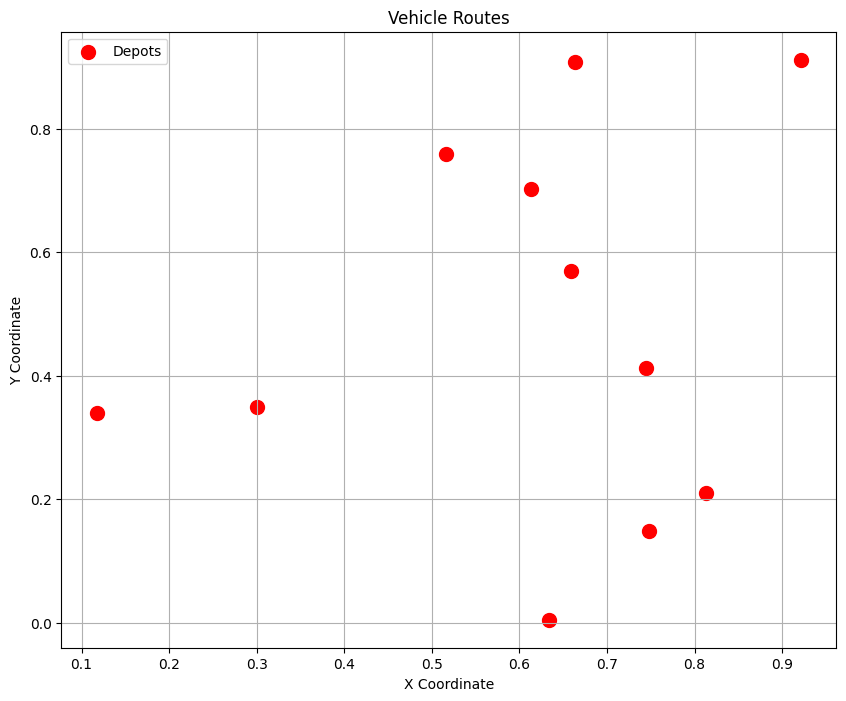

In [ ]:
import matplotlib.pyplot as plt

def visualize_routes(env):
    plt.figure(figsize=(10, 8))

    # Plot each route
    for route in env.routes:
        route = np.array(route)
        plt.plot(env.VRP[route, 0], env.VRP[route, 1], marker='o', linestyle='-', markersize=8, label=f'Route {route[0]}')

    # Plot the depots
    plt.scatter(env.VRP[:, 0], env.VRP[:, 1], color='red', s=100, label='Depots')

    plt.title('Vehicle Routes')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming env is already defined and has been used in evaluate_final_policy
visualize_routes(env)


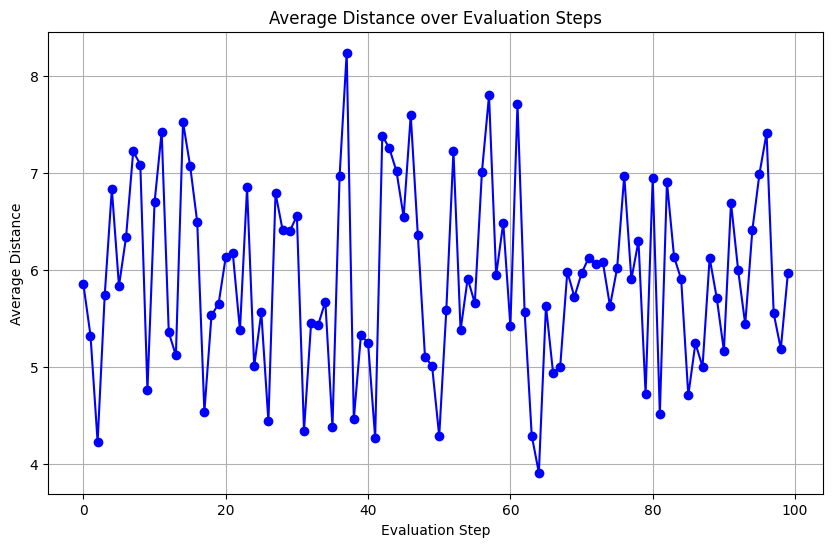

In [ ]:
import matplotlib.pyplot as plt

# Assuming 'results' contains the average distances over multiple evaluation steps
def plot_average_distances(results):
    plt.figure(figsize=(10, 6))
    plt.plot(results, marker='o', linestyle='-', color='b')
    plt.title('Average Distance over Evaluation Steps')
    plt.xlabel('Evaluation Step')
    plt.ylabel('Average Distance')
    plt.grid(True)
    plt.show()

# Assuming 'results' is already defined
plot_average_distances(results)


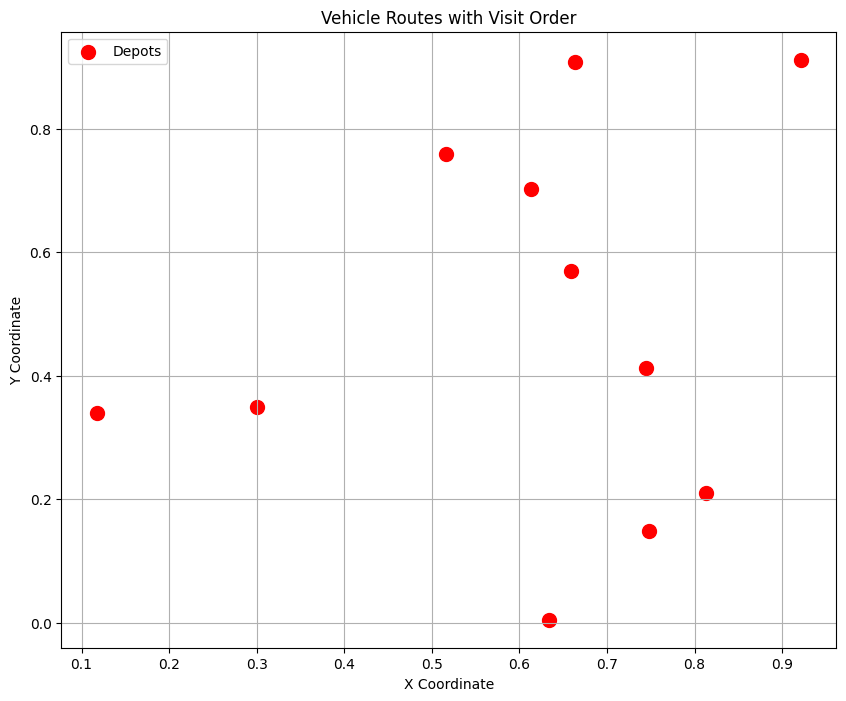

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_routes_with_order(env):
    plt.figure(figsize=(10, 8))

    # Plot each route
    for route_index, route in enumerate(env.routes):
        route = np.array(route)
        x_coords = env.VRP[route, 0]
        y_coords = env.VRP[route, 1]

        # Plot the route with lines connecting the points
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', markersize=8, label=f'Route {route_index+1}')

        # Annotate the order of visits
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

    # Plot the depots
    plt.scatter(env.VRP[:, 0], env.VRP[:, 1], color='red', s=100, label='Depots')

    plt.title('Vehicle Routes with Visit Order')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming env is already defined and has been used in evaluate_final_policy
visualize_routes_with_order(env)


Routes: []
VRP coordinates: [[0.81328617 0.21055764 0.         2.        ]
 [0.61370625 0.70149343 0.1        2.        ]
 [0.65937243 0.56940829 0.1        2.        ]
 [0.63398658 0.00470396 0.2        2.        ]
 [0.74432309 0.41295324 0.3        2.        ]
 [0.51580858 0.75924089 0.5        2.        ]
 [0.74819197 0.14873426 0.8        2.        ]
 [0.29997689 0.34837201 0.4        2.        ]
 [0.11708527 0.34016609 0.5        2.        ]
 [0.92155593 0.91149437 0.5        2.        ]
 [0.66361364 0.90857083 0.7        2.        ]]


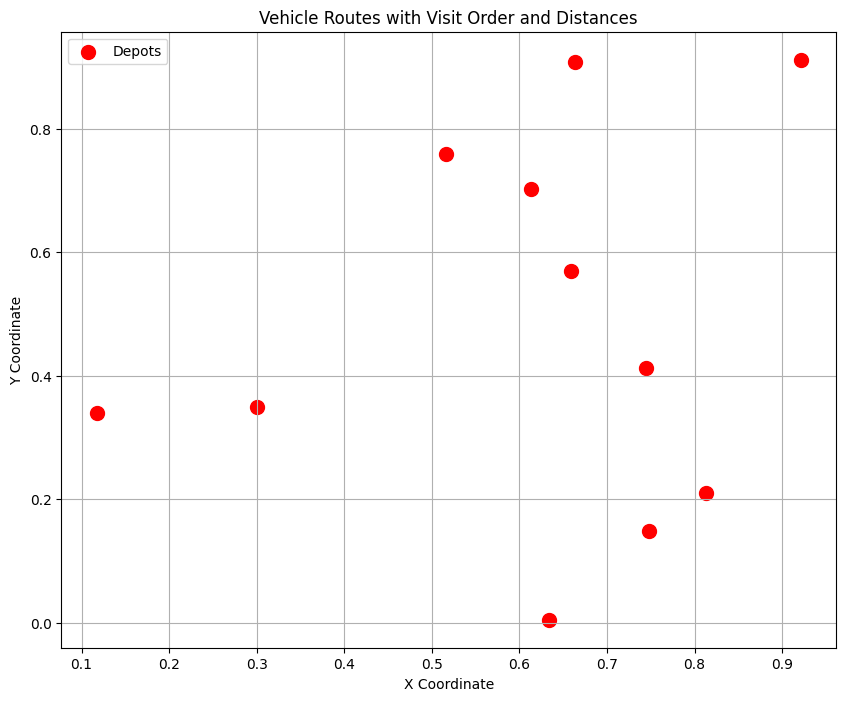

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_routes_with_distances(env):
    plt.figure(figsize=(10, 8))

    # Debugging: Print the routes and VRP coordinates
    print("Routes:", env.routes)
    print("VRP coordinates:", env.VRP)

    # Plot each route
    for route_index, route in enumerate(env.routes):
        route = np.array(route)
        x_coords = env.VRP[route, 0]
        y_coords = env.VRP[route, 1]

        # Plot the route with lines connecting the points
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', markersize=8, label=f'Route {route_index+1}')

        # Annotate the order of visits and distances
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
            if i > 0:
                prev_x, prev_y = x_coords[i-1], y_coords[i-1]
                distance = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)
                mid_x, mid_y = (x + prev_x) / 2, (y + prev_y) / 2
                plt.annotate(f'{distance:.2f}', (mid_x, mid_y), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    # Plot the depots
    plt.scatter(env.VRP[:, 0], env.VRP[:, 1], color='red', s=100, label='Depots')

    plt.title('Vehicle Routes with Visit Order and Distances')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Assuming env is already defined and has been used in evaluate_final_policy
visualize_routes_with_distances(env)


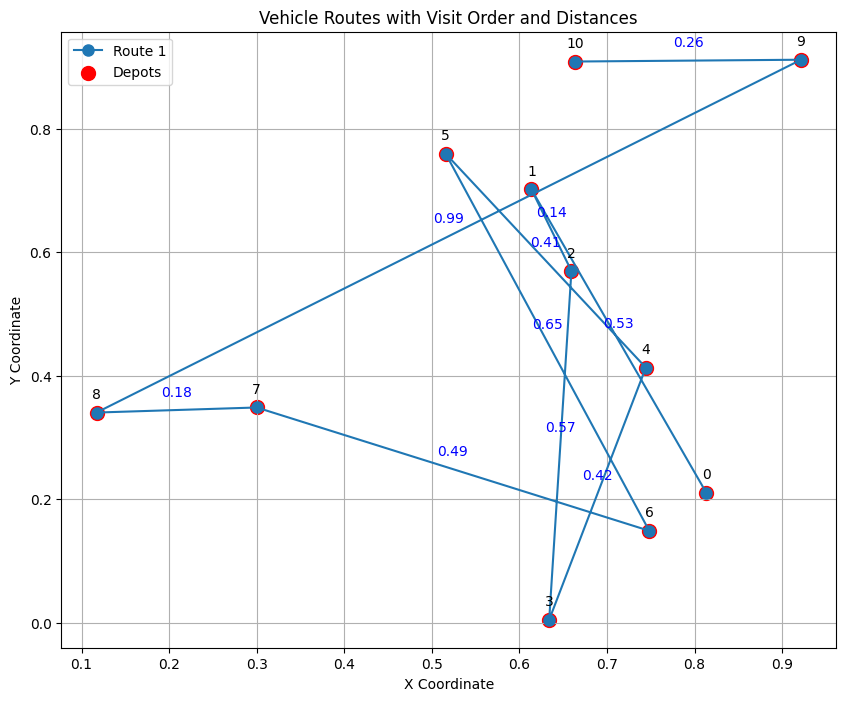

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Manually define a sample route that visits all points
# This example assumes a single route visiting all points sequentially
routes = [[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]]

# Assuming VRP coordinates as provided
VRP = np.array([
    [0.81328617, 0.21055764],
    [0.61370625, 0.70149343],
    [0.65937243, 0.56940829],
    [0.63398658, 0.00470396],
    [0.74432309, 0.41295324],
    [0.51580858, 0.75924089],
    [0.74819197, 0.14873426],
    [0.29997689, 0.34837201],
    [0.11708527, 0.34016609],
    [0.92155593, 0.91149437],
    [0.66361364, 0.90857083]
])

def visualize_routes_with_distances(VRP, routes):
    plt.figure(figsize=(10, 8))

    # Plot each route
    for route_index, route in enumerate(routes):
        route = np.array(route)
        x_coords = VRP[route, 0]
        y_coords = VRP[route, 1]

        # Plot the route with lines connecting the points
        plt.plot(x_coords, y_coords, marker='o', linestyle='-', markersize=8, label=f'Route {route_index+1}')

        # Annotate the order of visits and distances
        for i, (x, y) in enumerate(zip(x_coords, y_coords)):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')
            if i > 0:
                prev_x, prev_y = x_coords[i-1], y_coords[i-1]
                distance = np.sqrt((x - prev_x) ** 2 + (y - prev_y) ** 2)
                mid_x, mid_y = (x + prev_x) / 2, (y + prev_y) / 2
                plt.annotate(f'{distance:.2f}', (mid_x, mid_y), textcoords="offset points", xytext=(0,10), ha='center', color='blue')

    # Plot the depots
    plt.scatter(VRP[:, 0], VRP[:, 1], color='red', s=100, label='Depots')

    plt.title('Vehicle Routes with Visit Order and Distances')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize the manually defined routes
visualize_routes_with_distances(VRP, routes)
